In [31]:
# setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import http.client, urllib.request, urllib.parse, urllib.error, base64
# import config
import quickstart

In [32]:
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.

Failed to start a local web server. Please check your firewall
settings and locally running programs that may be blocking or
using configured ports. Default ports are 8080 and 8090.


AuthenticationError: 

In [5]:
from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)
fileList = drive.ListFile({'q': "'1jxSI_nq32-W9kPHKvQkzuNGJ5aIBD2j2' in parents and trashed=false"}).GetList()
for file in fileList:
  print('Title: %s, ID: %s' % (file['title'], file['id']))
  # Get the folder ID that you want
  if(file['title'] == "To Share"):
      fileID = file['id']

Title: analysis_box.csv, ID: 1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy
Title: analysis_bbl.csv, ID: 1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G
Title: analysis_bbl_noacs.csv, ID: 1h-tDpBSslfzqzsJe1ny_ujDnr68RKry3
Title: borobox_convex_hull.geojson, ID: 1SzBNj3Ba-v9MEwuCkZT9e9iAwVYUqx8r


In [6]:
csv = drive.CreateFile({'id': '1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G'})
csv.GetContentFile('analysis_bbl.csv')  

df = pd.read_csv('analysis_bbl.csv')

In [7]:
csv = df[["vacate_ind","hpd_b_c_vio", "bldgarea", "unitstotal", "pop65plus", "unitsres", "pctnhblack", "hpd_fire_vio"]]
csv.shape[0]
csv = csv.dropna()
csv.shape[0]

765026

In [8]:
hadFires = csv[csv["vacate_ind"] == 1]
noFires = csv[csv["vacate_ind"] == 0]
hadFires
noFires = noFires.sample(n=2604)

In [9]:
midData = pd.concat([hadFires, noFires], axis=0)

In [10]:
X = midData[["hpd_b_c_vio", "bldgarea", "unitstotal", "pop65plus", "unitsres", "pctnhblack", "hpd_fire_vio"]]
Y = midData[["vacate_ind"]]

In [11]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)
X=X_scaled
print(pd.DataFrame(X).head())

          0         1         2         3         4         5         6
0 -0.185772  0.314870  0.250977  3.654770  0.255888 -0.474204 -0.350781
1  0.330355  2.514825  1.853149  3.654770  1.825582 -0.474204 -0.350781
2 -0.339330  1.540015  0.777063  3.654770  0.771095 -0.474204 -0.350781
3 -0.322268  1.815038  1.016193  3.654770  0.997400 -0.474204 -0.350781
4 -0.245489 -0.122820 -0.102936 -0.651114 -0.110053 -0.398508 -0.350781


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=90)

In [13]:
print(len(X_train), len(Y_train))

3489 3489


In [14]:
from sklearn import svm
clf = svm.SVC(kernel='linear',C=1)

In [15]:
clf.fit(X_train, Y_train["vacate_ind"])
correct=1.0*(clf.predict(X_test) == np.asarray(Y_test).reshape(1,X_test.shape[0])).sum()/len(Y_test)
print("Out of sample, linear model successfully predicts {} percent of the data".format((correct)))

Out of sample, linear model successfully predicts 0.8807446189645143 percent of the data


In [16]:
# from sklearn.model_selection import GridSearchCV

# param_grid ={'kernel':["linear"],
#             'C':[np.exp(i) for i in np.linspace(-5,5,100)]}

# OS = []
# for i in range(10):
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=i)
#     rr=svm.SVC()
#     gr=GridSearchCV(rr,param_grid=param_grid)
#     rs=gr.fit(X_train,Y_train["vacate_ind"])
#     print(rs.best_estimator_)
#     correct=1.0*(rs.predict(X_test)==np.asarray(Y_test).reshape(1,X_test.shape[0])).sum()/len(Y_test)
#     OS.append(correct)
# print("Out of sample, we successfully predict",np.mean(OS)*100,"percent of the data")

In [18]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.33,random_state=70)

C = [np.exp(i) for i in np.linspace(-5,5,300)]
OS = []
for c in C:
    clf = svm.SVC(kernel='linear',C=c) 
    clf.fit(X_train, Y_train["vacate_ind"])
    correct=1.0*(clf.predict(X_test)==np.asarray(Y_test).reshape(1,X_test.shape[0])).sum()/len(Y_test)
    OS.append(correct)

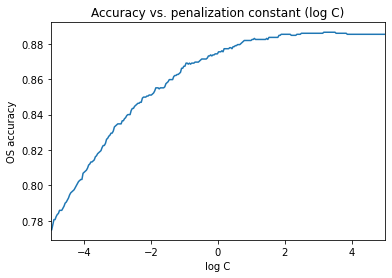

In [22]:
pl.gca()
pl.plot(np.linspace(-5,5,300),OS)
pl.xlabel("log C")
pl.ylabel("OS accuracy")
pl.title("Accuracy vs. penalization constant (log C)")
pl.xlim(-5,5)
pl.show()

In [23]:
clf.predict(X_test)

array([1., 0., 0., ..., 1., 0., 0.])

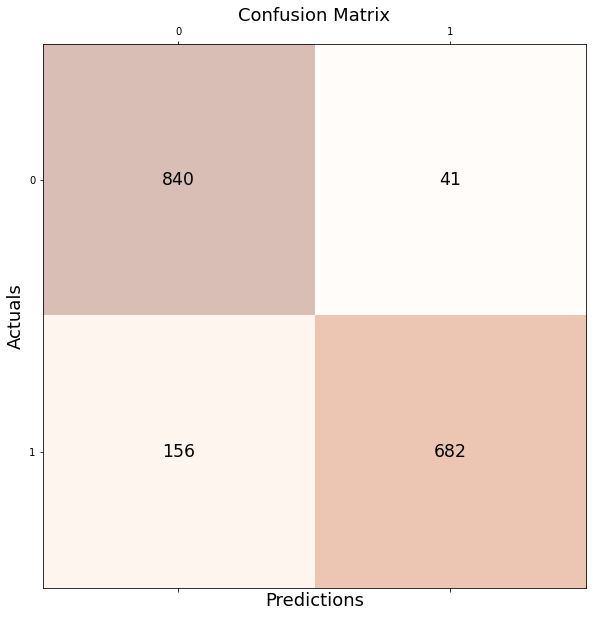

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_pred = clf.predict(X_test)
#
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = pl.subplots(figsize=(10, 10))
ax.matshow(conf_matrix, cmap=pl.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
pl.xlabel('Predictions', fontsize=18)
pl.ylabel('Actuals', fontsize=18)
pl.title('Confusion Matrix', fontsize=18)
pl.show()


In [27]:
from sklearn import metrics
preds = clf.predict(X_test)
# X_train, X_test, Y_train, Y_test
targs = Y_test
print("accuracy: ", metrics.accuracy_score(targs, preds))
print("precision: ", metrics.precision_score(targs, preds)) 
print("recall: ", metrics.recall_score(targs, preds))
print("f1: ", metrics.f1_score(targs, preds))
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))
test_preds = preds

accuracy:  0.8853984874927283
precision:  0.9432918395573997
recall:  0.8138424821002387
f1:  0.8737988468930172
area under curve (auc):  0.8836522285643077


### PART 2: Alarm Box Tracts

In [29]:
csv = drive.CreateFile({'id': '1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy'})
# Title: analysis_box.csv, ID: 1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy
csv.GetContentFile('analysis_box.csv')  

df = pd.read_csv('analysis_box.csv')

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=570719947456-53haph7mjc317oel1ujh0kmjbfd499jf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8090%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code



KeyboardInterrupt: 